In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import src.python.yalefaces as yalefaces

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

np.random.seed(15)

## Data preprocessing

### Load dataset

In [2]:
X, y = yalefaces.load("datasets/yalefaces", flatten=True)

### Plot dataset

<Figure size 432x288 with 0 Axes>

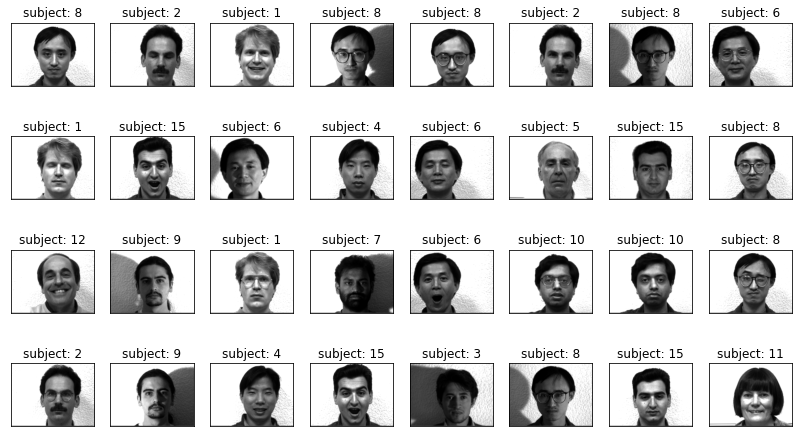

In [3]:
num_faces, num_pixels = X.shape

plt.figure()
f, axes = plt.subplots(4,8, figsize=(14, 8), sharey=True)

for ax in axes:
    for axy in ax:
        # select a random face
        face = np.random.randint(0, num_faces)
        
        # format image and label as in the raw dataset
        face_img = X[face].reshape(yalefaces.SHAPE)
        face_label = y[face] + 1

        # plot face
        axy.imshow(face_img, cmap='gray')
        
        # show only relevant information
        axy.set_title(f"subject: {face_label}")
        axy.set_xticks([])
        axy.set_yticks([])
plt.show()

### Identify most relevant pixels

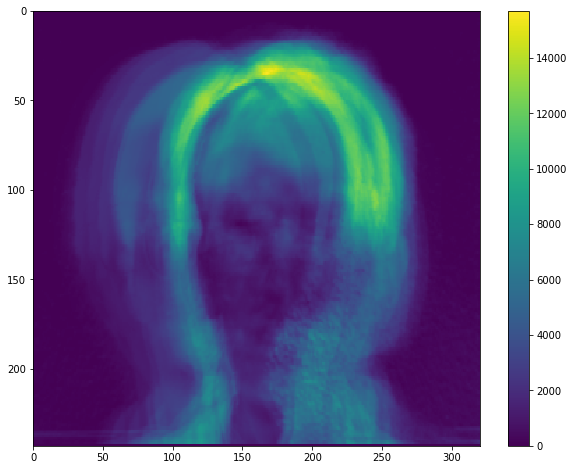

In [4]:
from sklearn.feature_selection import chi2

score, _ = chi2(X, y)
score_img = (np.array(score)).reshape(yalefaces.SHAPE)

plt.figure(figsize=(10, 8))

colormesh = plt.pcolormesh(score_img)
plt.colorbar(colormesh)

# mirror the y-axis because pcolormesh doesn't
# do this trick automatically as imgshow does.
plt.gca().invert_yaxis()
plt.show()

## Reduce number of dimensions

### Plot explained variance ratio

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

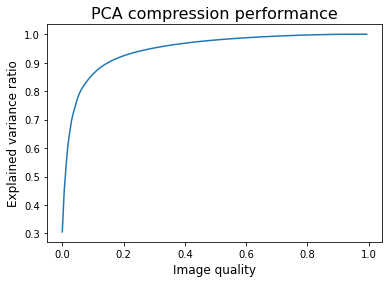

In [6]:
plt.plot(np.arange(num_faces)/165, np.cumsum(pca.explained_variance_ratio_))

plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Image quality", size=12)

plt.show()

### Choose image quality and compress images with PCA

In [7]:
image_quality = 1
n_components = int(num_faces * image_quality)

pca = PCA(n_components=n_components)
pca.fit(X)
X_compressed = pca.transform(X)
X_reconstructed = pca.inverse_transform(X_compressed)

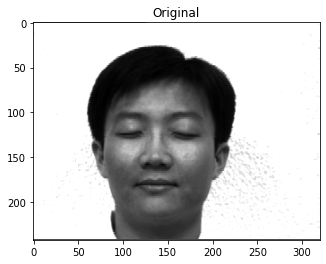

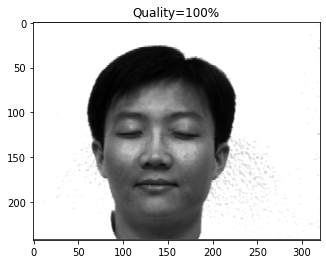

In [8]:
plt.imshow(X[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title("Original")
plt.show()

plt.imshow(X_reconstructed[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title(f"Quality={image_quality*100}%")
plt.show()

### Prepare datasets (original and compressed)

In [9]:
from sklearn.model_selection import train_test_split

# original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# compressed
X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

## Logistic Regression

### Train and test on the original dataset

In [127]:
lr_param_grid = [{'C':[0.00001, 0.0001, 0.001, 0.01, 0.01, 1], 'max_iter':[7600]}]
lr_grid_search = GridSearchCV(estimator = LogisticRegression(), 
    param_grid = lr_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True)

lr_classifier = lr_grid_search.fit(X_train, y_train)

In [128]:
print("Train score (original):", lr_grid_search.best_score_)
print("Best params (original):", lr_grid_search.best_params_)
lr_cv_result = pd.DataFrame(lr_grid_search.cv_results_)
lr_cv_result.head()

Train score (original): 0.9043478260869566
Best params (original): {'C': 0.0001, 'max_iter': 7600}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,33.965253,1.246415,0.011832,0.000594,0.00001,7600,"{'C': 1e-05, 'max_iter': 7600}",1.000000,1.0,0.826087,...,0.895652,0.085200,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,36.264992,1.761724,0.012625,0.000496,0.0001,7600,"{'C': 0.0001, 'max_iter': 7600}",1.000000,1.0,0.826087,...,0.904348,0.079697,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,36.224665,1.696875,0.012906,0.000465,0.001,7600,"{'C': 0.001, 'max_iter': 7600}",1.000000,1.0,0.826087,...,0.895652,0.085200,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,34.405384,2.161623,0.012171,0.000306,0.01,7600,"{'C': 0.01, 'max_iter': 7600}",0.956522,1.0,0.826087,...,0.895652,0.070644,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,34.466101,1.578307,0.013461,0.000915,0.01,7600,"{'C': 0.01, 'max_iter': 7600}",0.956522,1.0,0.826087,...,0.895652,0.070644,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Train score (original): 0.9043478260869566
Best params (original): {'C': 0.0001, 'max_iter': 7600}
Score (original): 0.92
{'C': 0.0001, 'max_iter': 7600}
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      0.75      0.75         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       0.80      1.00      0.89         4
          13       1.00      0.67      0.80         3
          14       0.75      1.00  

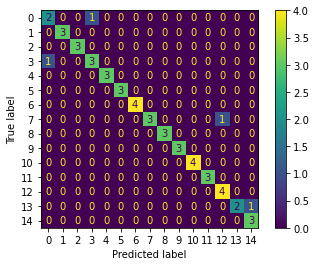

In [129]:
print("Train score (original):", lr_grid_search.best_score_)
print("Best params (original):", lr_grid_search.best_params_)

print("Score (original):", lr_classifier.score(X_test, y_test))
print(lr_grid_search.best_params_)

lr_pred = lr_classifier.predict(X_test)
print(metrics.classification_report(y_test, lr_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)

### Train and test on the compressed dataset

In [130]:
lr_grid_search_compressed = GridSearchCV(estimator = LogisticRegression(), 
    param_grid = lr_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True)

lr_classifier_compressed = lr_grid_search_compressed.fit(X_train_compressed, y_train_compressed)

In [131]:
print("Train score (original):", lr_grid_search_compressed.best_score_)
print("Best params (original):", lr_grid_search_compressed.best_params_)
lr_cv_result_compressed = pd.DataFrame(lr_grid_search_compressed.cv_results_)
lr_cv_result_compressed.head()

Train score (original): 0.8782608695652174
Best params (original): {'C': 1, 'max_iter': 7600}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.072402,0.037656,0.000391,0.000043,0.00001,7600,"{'C': 1e-05, 'max_iter': 7600}",0.913043,0.956522,0.826087,...,0.852174,0.070644,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.050028,0.002449,0.000518,0.000139,0.0001,7600,"{'C': 0.0001, 'max_iter': 7600}",0.913043,0.956522,0.826087,...,0.860870,0.063900,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.049828,0.003252,0.000407,0.000047,0.001,7600,"{'C': 0.001, 'max_iter': 7600}",0.913043,0.956522,0.826087,...,0.860870,0.063900,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.051564,0.003718,0.000424,0.000055,0.01,7600,"{'C': 0.01, 'max_iter': 7600}",0.913043,0.956522,0.826087,...,0.860870,0.063900,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.047879,0.001780,0.000402,0.000044,0.01,7600,"{'C': 0.01, 'max_iter': 7600}",0.913043,0.956522,0.826087,...,0.860870,0.063900,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Score (compressed): 0.92
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      0.75      0.86         4
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       0.80      1.00      0.89         4
          13       1.00      1.00      1.00         3
          14       0.75      1.00      0.86         3

    accuracy                           0.92        50
   macro avg       0.94      0.92      0.92        50
w

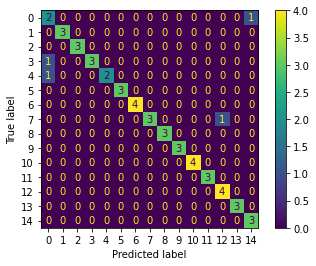

In [132]:
print("Score (compressed):", lr_classifier_compressed.score(X_test_compressed, y_test_compressed))

lr_pred_compressed = lr_classifier_compressed.predict(X_test_compressed)
print(metrics.classification_report(y_test_compressed, lr_pred_compressed))
ConfusionMatrixDisplay.from_predictions(y_test_compressed, lr_pred_compressed)

## KNN

### Train and test on the original dataset

In [133]:
knn_param_grid = [{'C':[0.00001, 0.0001, 0.001, 0.01, 0.01, 1], 'max_iter':[7600]}]
lr_grid_search = GridSearchCV(estimator = KNeighborsClassifier(), 
    param_grid = knn_param_grid, scoring = 'accuracy', cv = 5, verbose=0)

knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

Score (original): 0.8


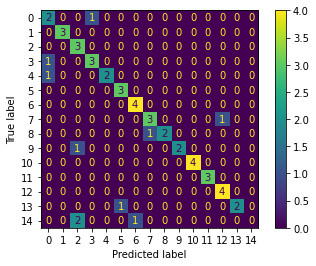

In [34]:
print("Score (original):", knn_classifier.score(X_test, y_test))

knn_pred = knn_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

### Train and test on the compressed dataset

In [38]:
knn_classifier_compressed = KNeighborsClassifier(n_neighbors=2)
knn_classifier_compressed.fit(X_train_compressed, y_train_compressed)

KNeighborsClassifier(n_neighbors=2)

Score (compressed): 0.8


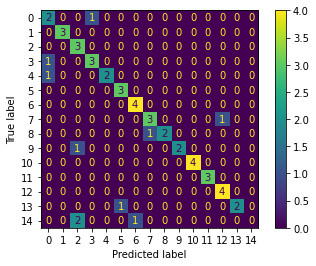

In [39]:
print("Score (compressed):", knn_classifier_compressed.score(X_test_compressed, y_test_compressed))

knn_pred_compressed = knn_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, knn_pred_compressed)

## Neural Networks

### Train and test on the original dataset

In [77]:
mlp_classifier = MLPClassifier(solver='adam', learning_rate_init=0.001, random_state=1)
mlp_classifier.fit(X_train, y_train)

MLPClassifier(random_state=1)

Score (original): 0.36


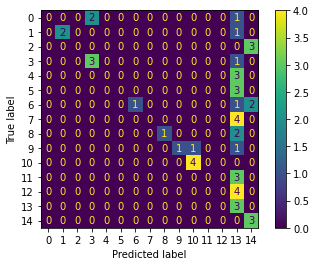

In [76]:
print("Score (original):", mlp_classifier.score(X_test, y_test))

mlp_pred= mlp_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, mlp_pred)

### Train and test on the compressed dataset

In [78]:
mlp_classifier_compressed = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1)
mlp_classifier_compressed.fit(X_train_compressed, y_train_compressed)

MLPClassifier(learning_rate_init=0.1, random_state=1)

Score (compressed): 0.8


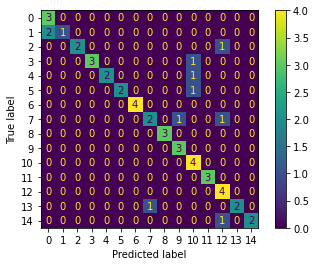

In [79]:
print("Score (compressed):", mlp_classifier_compressed.score(X_test_compressed, y_test_compressed))

mlp_pred_compressed = mlp_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, mlp_pred_compressed)

## Convolutional Neural Networks

In [10]:
from keras import backend as K
from keras.optimizers import SGD
from src.python.models.lenet import LeNet

cnn = LeNet.build(numChannels=1, imgRows=243, imgCols=320, numClasses=15, weightsPath=None)

cnn.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])


2022-07-02 14:13:47.575349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 14:13:47.575374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-02 14:13:48.904966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-02 14:13:48.905599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 14:13:48.905657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [11]:
from keras.utils import to_categorical

if K.image_data_format() == "channels_first":
	cnn_trainX = X_train.reshape((X_train.shape[0], 1, 243, 320))
	cnn_testX = X_test.reshape(X_test.shape[0], 1, 243, 320)
else:
	cnn_trainX = X_train.reshape(X_train.shape[0], 243, 320, 1)
	cnn_testX = X_test.reshape(X_test.shape[0], 243, 320, 1)


# scale data to the range of [0, 1]
cnn_trainX = cnn_trainX.astype("float32") / 255.0
cnn_testX = cnn_testX.astype("float32") / 255.0


cnn_train_y = to_categorical(y_train)
cnn_test_y = to_categorical(y_test)

In [12]:
cnn.fit(cnn_trainX, cnn_train_y, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 2.7210 - accuracy: 0.0696
Epoch 2/50
4/4 [==============================] - 7s 2s/step - loss: 2.6373 - accuracy: 0.1913
Epoch 3/50
4/4 [==============================] - 7s 2s/step - loss: 2.5282 - accuracy: 0.1217
Epoch 4/50
4/4 [==============================] - 7s 2s/step - loss: 2.5650 - accuracy: 0.2522
Epoch 5/50
4/4 [==============================] - 7s 2s/step - loss: 2.2948 - accuracy: 0.3652
Epoch 6/50
4/4 [==============================] - 7s 2s/step - loss: 2.1727 - accuracy: 0.3652
Epoch 7/50
4/4 [==============================] - 7s 2s/step - loss: 2.5333 - accuracy: 0.3478
Epoch 8/50
4/4 [==============================] - 7s 2s/step - loss: 2.1962 - accuracy: 0.4696
Epoch 9/50
4/4 [==============================] - 7s 2s/step - loss: 1.8177 - accuracy: 0.4870
Epoch 10/50
4/4 [==============================] - 7s 2s/step - loss: 2.0638 - accuracy: 0.4783
Epoch 11/50
4/4 [==============================] 

In [14]:
(loss, accuracy) = cnn.evaluate(cnn_testX, cnn_test_y,
		batch_size=16, verbose=1)

4/4 [==============================] - 1s 161ms/step - loss: 0.4022 - accuracy: 0.9000
